This module provides a way to plot distribution of 1D ordered data with order provided as a separate feature.

The module abstract a data request that I encounter at work
* There are two types of digital meters, called "A" & "B". - This is what the `datacategory` in this module abstracts.
* Some meters are not returning digital reads from some point. We calculate the days since their last returning some data for these meters. - This is what `dataseries` in this module abstracts.
* We then group the meters by no. of missing days and get how many meters for each different no. of missing days - This is what `datacounts` in this module abstracts.
* Then we need to present this insight for people to further investigate - This is why this plot is being made

Lastly, the plot in this module can be embedded in PowerBI for interactive filtering with other visuals

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# data pre-calculation (faking the data for this presentation purpose)
rng = np.random.default_rng(3)
dataseries = range(100)
datacategory = rng.choice(['B', 'A'], size=100, replace=True)
datacounts = (rng.lognormal(size = 100) * 10).astype(int)
missingindex = np.abs((rng.standard_normal(size = 10) * 100).astype(int)) # simulate some index rows missing
df = pd.DataFrame({'dataseries': dataseries, 'datacategory': datacategory, 'datacounts': datacounts})
df = df[~df.index.isin(missingindex)].sort_values(['dataseries']).reset_index(drop = True)
df

,dataseries,datacategory,datacounts
0,1,B,8
1,2,B,3
2,3,B,17
3,4,B,17
4,5,A,8
...,...,...,...
87,95,B,5
88,96,A,3
89,97,A,2
90,98,A,16


In [3]:
# this is where we start preparing data for plot and should be the starting point in your dataset 
# make up the non-consecutive numbers in the consecutive series
dfa = df.query('datacategory == "A"').drop('datacategory', axis = 1).copy()
dfb = df.query('datacategory == "B"').drop('datacategory', axis = 1).copy()

start = dfa.dataseries.min()
end = dfa.dataseries.max()

# fill missing data in the consecutive series
dummy = pd.DataFrame({'dataseries': range(start, end + 1)})
dfa = dummy.merge(dfa, on = 'dataseries', how = 'left').fillna(0)
dfb = dummy.merge(dfb, on = 'dataseries', how = 'left').fillna(0)

# barplot pre-calculation 
bins = 10
bininterval = (end - start) // 10
binrange = [start + (i * bininterval) for i in range(bins + 2)]

dfa['binrange'] = pd.cut(dfa.dataseries, binrange, right = False)
dfa = dfa.groupby('binrange').datacounts.sum().reset_index()

dfb['binrange'] = pd.cut(dfb.dataseries, binrange, right = False)
dfb = dfb.groupby('binrange').datacounts.sum().reset_index()

dfa.binrange = dfa.binrange.apply(lambda s: s.left)
dfb.binrange = dfb.binrange.apply(lambda s: s.left)
dfa
dfb

,binrange,datacounts
0,5,34.0
1,14,29.0
2,23,152.0
3,32,50.0
4,41,50.0
5,50,23.0
6,59,170.0
7,68,114.0
8,77,77.0
9,86,137.0


,binrange,datacounts
0,5,35.0
1,14,73.0
2,23,26.0
3,32,70.0
4,41,46.0
5,50,78.0
6,59,89.0
7,68,69.0
8,77,83.0
9,86,58.0


In [4]:
InteractiveShell.ast_node_interactivity = "last"

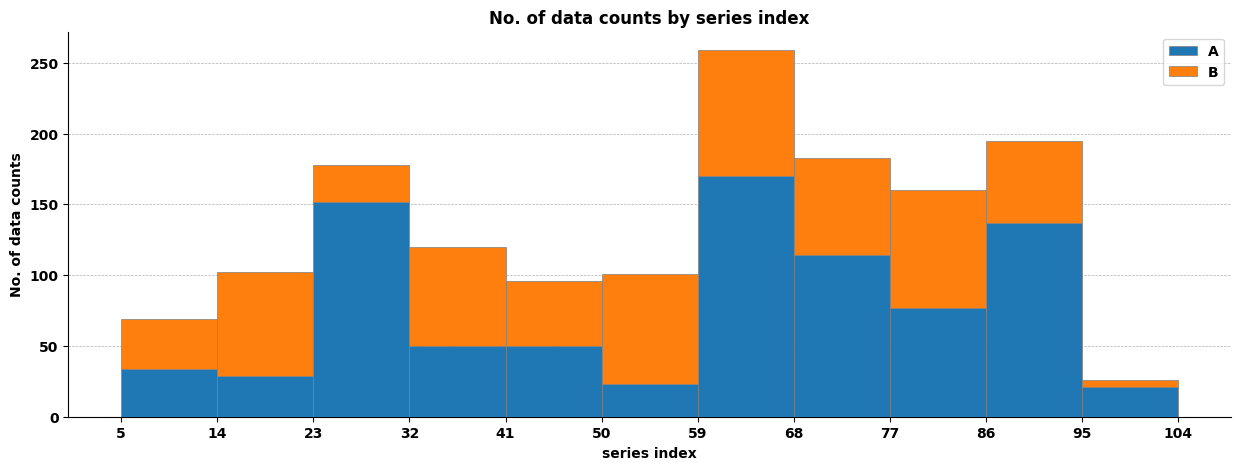

In [5]:
fig, ax = plt.subplots(figsize = (15, 5))

bara = ax.bar('binrange', 'datacounts', data = dfa, width = bininterval, align = 'edge', label = 'A', edgecolor = "grey", linewidth = 0.5, color = 'C0', zorder = 3)
barb = ax.bar('binrange', 'datacounts', data = dfb, bottom = dfa.datacounts, width = bininterval, align = 'edge', label = 'B', edgecolor = "grey", linewidth = 0.5, color = 'C1', zorder = 3)
ax.set_xticks(binrange)
ax.set_xticklabels(binrange)

# ax.bar_label(bara, dfa.datacounts.astype(int).to_numpy(), label_type = 'center')
# ax.bar_label(barb, dfb.datacounts.astype(int).to_numpy(), label_type = 'edge', color = 'C1')

ax.legend()
ax.set(title = 'No. of data counts by series index', xlabel = 'series index', ylabel = 'No. of data counts')
ax.spines[['top', 'right']].set_visible(False)

ax.grid(axis = 'y', visible = True, linestyle='--', linewidth = 0.5)
plt.show()